#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [4]:
#!pip install catboost
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier  # Можно заменить на XGBClassifier или LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
# 1) Предобработка данных
data = pd.read_csv("combined_data_short.csv")

# Приведение к нижнему регистру
data['text'] = data['text'].str.lower()

# Функция очистки текста
def clean_text(text):
    # Удаляем пунктуацию и числа, заменяя их на пробел
    text = re.sub(r'[\d]+', ' ', text)
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    # Токенизация
    tokens = nltk.word_tokenize(text)
    # Удаляем стоп-слова
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words and w.strip() != '']
    return tokens

data['tokens'] = data['text'].apply(clean_text)

# Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме.
lemmatizer = WordNetLemmatizer()
data['lemmas'] = data['tokens'].apply(lambda tok: [lemmatizer.lemmatize(t) for t in tok])

# Склеим лемматизированный текст обратно для векторизации
data['clean_text'] = data['lemmas'].apply(lambda x: ' '.join(x))
data.head()

,label,text,tokens,lemmas,clean_text
0,1,ounce feather bowl hummingbird opec moment ala...,"[ounce, feather, bowl, hummingbird, opec, mome...","[ounce, feather, bowl, hummingbird, opec, mome...",ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,"[wulvob, get, medircations, online, qnb, ikud,...","[wulvob, get, medircations, online, qnb, ikud,...",wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,"[computer, connection, cnn, com, wednesday, es...","[computer, connection, cnn, com, wednesday, es...",computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,"[university, degree, obtain, prosperous, futur...","[university, degree, obtain, prosperous, futur...",university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,"[thanks, answers, guys, know, checked, rsync, ...","[thanks, answer, guy, know, checked, rsync, ma...",thanks answer guy know checked rsync manual wo...


In [13]:
# 2) Разбиение на train и test (80%/20%) 4:1
X = data['clean_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [14]:
# 3) Векторизация

# Bag of Words - представление текста в виде массива, состоящего из отдельных слов и количества их использования.
n = 120
bow_vectorizer = CountVectorizer(max_features=n)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF - статистическая мера, используемая для оценки важности слова в контексте документа,
# являющегося частью коллекции документов или корпуса.
tfidf_vectorizer = TfidfVectorizer(max_features=n)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [15]:
# 4) Обучение моделей с подбором гиперпараметров

# Логистическая регрессия
logreg = LogisticRegression(max_iter=1000)
params_logreg = {'C': [0.1, 1, 10]}  # Пример простой сетки
gs_logreg_bow = GridSearchCV(logreg, params_logreg, cv=3, scoring='f1')  # Для BOW
gs_logreg_bow.fit(X_train_bow, y_train)

gs_logreg_tfidf = GridSearchCV(logreg, params_logreg, cv=3, scoring='f1') # Для TF-IDF
gs_logreg_tfidf.fit(X_train_tfidf, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators': [30, 60], 'max_depth': [None, 5]}
gs_rf_bow = GridSearchCV(rf, params_rf, cv=3, scoring='f1')
gs_rf_bow.fit(X_train_bow, y_train)

gs_rf_tfidf = GridSearchCV(rf, params_rf, cv=3, scoring='f1')
gs_rf_tfidf.fit(X_train_tfidf, y_train)

# CatBoost
cb = CatBoostClassifier(verbose=0, random_state=42)
params_cb = {'iterations': [30, 60], 'depth': [3, 5]}
gs_cb_bow = GridSearchCV(cb, params_cb, cv=3, scoring='f1')
gs_cb_bow.fit(X_train_bow, y_train)

gs_cb_tfidf = GridSearchCV(cb, params_cb, cv=3, scoring='f1')
gs_cb_tfidf.fit(X_train_tfidf, y_train)

# Выберем, например, лучшие модели по TF-IDF (можно было и по BOW)
best_logreg_tfidf = gs_logreg_tfidf.best_estimator_
best_rf_tfidf = gs_rf_tfidf.best_estimator_
best_cb_tfidf = gs_cb_tfidf.best_estimator_

Модель: Logistic Regression
Accuracy: 0.9044
Precision: 0.8870
Recall: 0.9349
F1-Score: 0.9103
ROC-AUC: 0.9617866599369489
----------


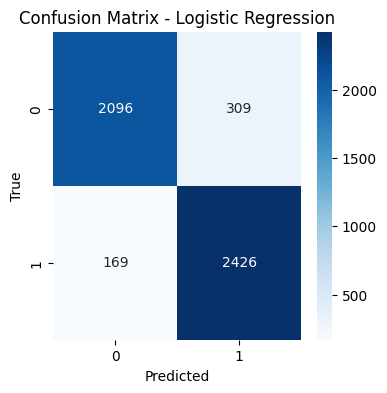

Модель: Random Forest
Accuracy: 0.9470
Precision: 0.9321
Recall: 0.9684
F1-Score: 0.9499
ROC-AUC: 0.9846551219961625
----------


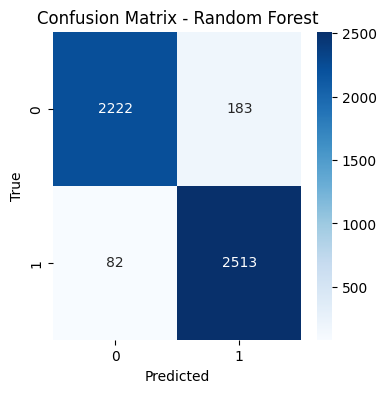

Модель: CatBoost
Accuracy: 0.9378
Precision: 0.9186
Recall: 0.9657
F1-Score: 0.9416
ROC-AUC: 0.9825117069047704
----------


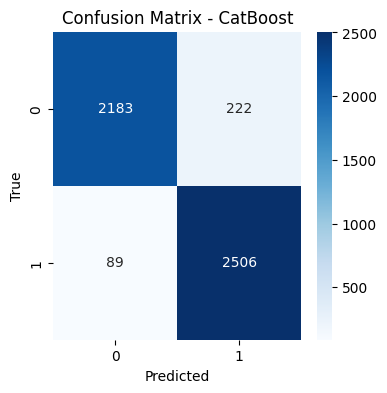

In [16]:
# 5) Оценка качества
models = {
    'Logistic Regression': best_logreg_tfidf,
    'Random Forest': best_rf_tfidf,
    'CatBoost': best_cb_tfidf
}

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:,1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'

    print(f"Модель: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc}")
    print("----------")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Краткий вывод:
# Судя по рассчитанным метрикам лучше всего себя показали модели: Случайный лес, Градиентный бустинг.
# Логистическая регрессия показала результат хуже.

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

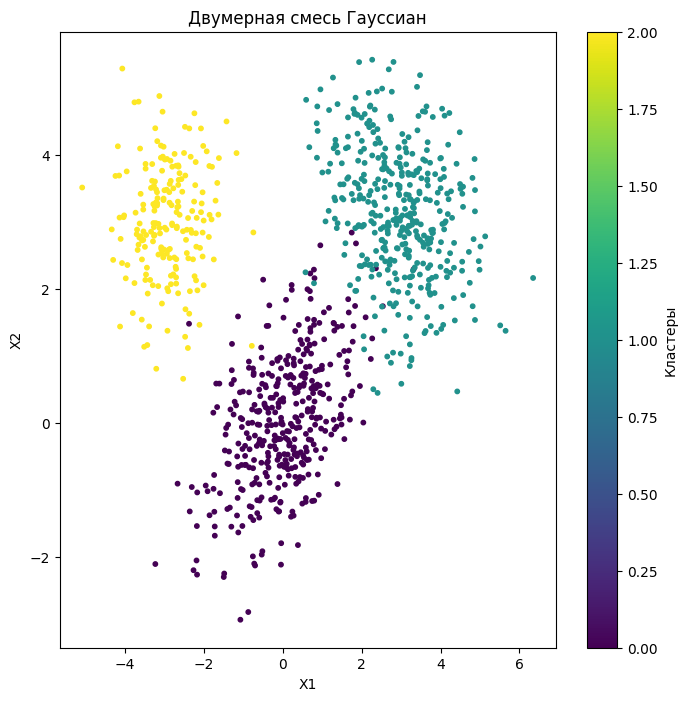

In [17]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

Оптимальное число кластеров по силуэтному коэффициенту: 3
Максимальный силуэтный коэффициент: 0.6064


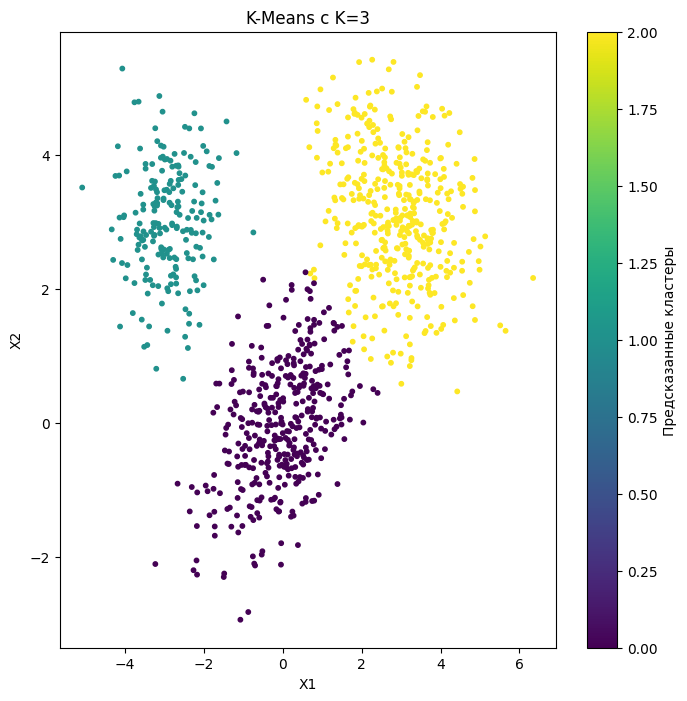

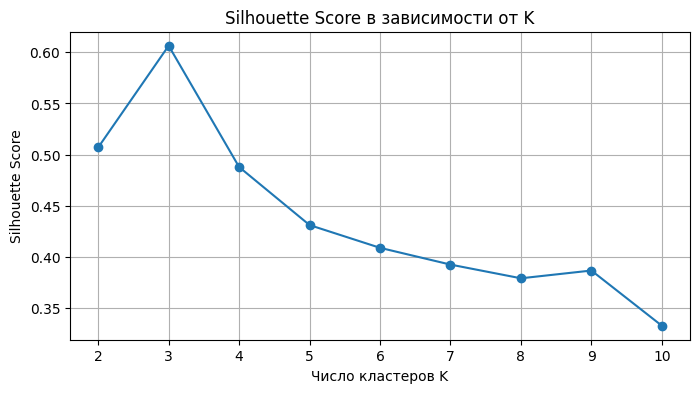

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Подбор K по силуэту
K_values = range(2, 11)  # Проверяем K от 2 до 10
silhouette_scores = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_k = K_values[np.argmax(silhouette_scores)]

print(f"Оптимальное число кластеров по силуэтному коэффициенту: {best_k}")
print(f"Максимальный силуэтный коэффициент: {max(silhouette_scores):.4f}")

# Обучаем модель K-Means с лучшим K
best_kmeans = KMeans(n_clusters=best_k, random_state=42)
pred_labels = best_kmeans.fit_predict(X)

# Отображаем результаты кластеризации
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=pred_labels, cmap='viridis', s=10)
plt.title(f"K-Means с K={best_k}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Предсказанные кластеры")
plt.show()

# Визуализация зависимости силуэта от K
plt.figure(figsize=(8, 4))
plt.plot(K_values, silhouette_scores, marker='o')
plt.title("Silhouette Score в зависимости от K")
plt.xlabel("Число кластеров K")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

Лучшие параметры: eps=0.40, min_samples=9
Максимальный BCubed F1: 0.8252


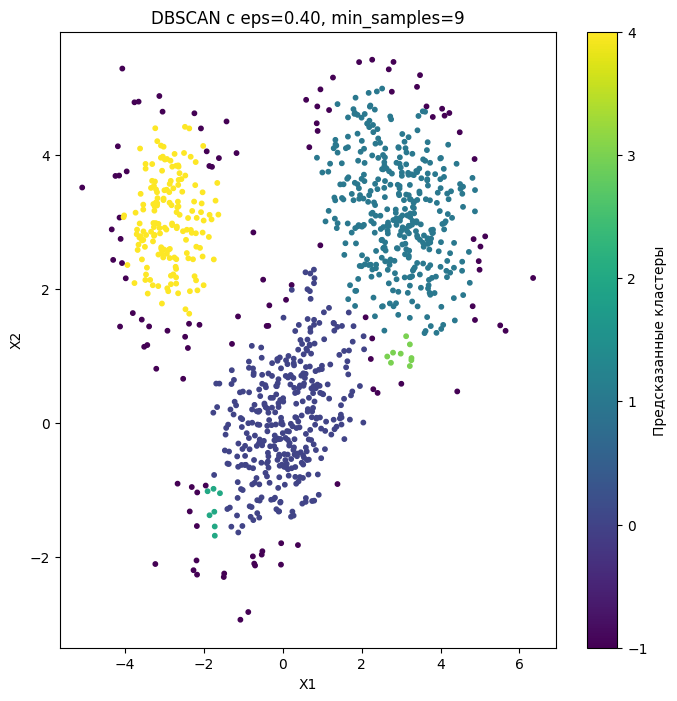

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def bcubed_score(true_labels, pred_labels):
    # Рассчёт BCubed Precision, Recall, F1
    # Условие: шумовые точки DBSCAN имеют label = -1, они также учитываются.
    n = len(true_labels)

    # Индексы элементов по кластерам предсказанным
    from collections import defaultdict
    pred_clusters = defaultdict(set)
    true_clusters = defaultdict(set)
    for i in range(n):
        pred_clusters[pred_labels[i]].add(i)
        true_clusters[true_labels[i]].add(i)

    precisions = []
    recalls = []
    for i in range(n):
        pred_cluster = pred_clusters[pred_labels[i]]
        true_cluster = true_clusters[true_labels[i]]

        intersection = pred_cluster.intersection(true_cluster)
        if len(pred_cluster) > 0:
            p = len(intersection) / len(pred_cluster)
        else:
            p = 0.0
        if len(true_cluster) > 0:
            r = len(intersection) / len(true_cluster)
        else:
            r = 0.0
        precisions.append(p)
        recalls.append(r)

    precision = np.mean(precisions)
    recall = np.mean(recalls)
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

# Подбор гиперпараметров eps и min_samples
# eps можно перебирать, например, от 0.1 до 1.0 с шагом 0.1
# min_samples можно перебирать, например, от 2 до 10
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(2, 11)

best_f1 = -1
best_params = (None, None)

for eps in eps_values:
    for min_s in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_s)
        pred_labels = dbscan.fit_predict(X)

        # Рассчет BCubed метрики
        _, _, f1 = bcubed_score(labels, pred_labels)

        if f1 > best_f1:
            best_f1 = f1
            best_params = (eps, min_s)

print(f"Лучшие параметры: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
print(f"Максимальный BCubed F1: {best_f1:.4f}")

# Обучаем DBSCAN с лучшими параметрами
best_dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
pred_labels_best = best_dbscan.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=pred_labels_best, cmap='viridis', s=10)
plt.title(f"DBSCAN с eps={best_params[0]:.2f}, min_samples={best_params[1]}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Предсказанные кластеры")
plt.show()

**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

EM сошёлся на итерации 42, log-likelihood=-3618.590


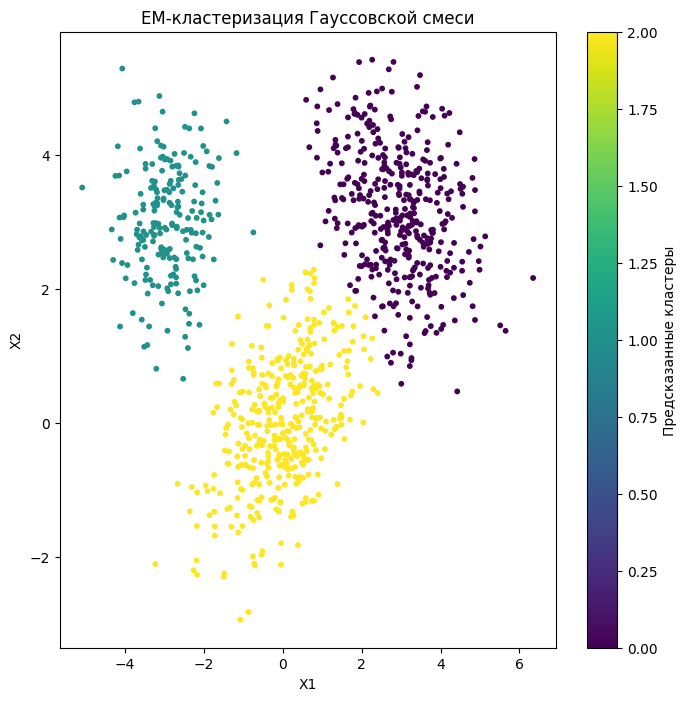

In [20]:
from scipy.stats import multivariate_normal

# Предположим, мы знаем число кластеров (компонент смеси):
K = 3
N, D = X.shape

# Инициализация параметров ГММ:
# Инициализация средних (случайно выбираем точки из данных)
np.random.seed(0)
mu = X[np.random.choice(N, K, replace=False)]
# Инициализация ковариационных матриц (сначала пусть будут единичные)
Sigma = [np.eye(D) for _ in range(K)]
# Инициализация весов смеси (равномерно)
pi_k = np.ones(K) / K

max_iter = 100
tol = 1e-5
prev_log_likelihood = None

for iteration in range(max_iter):
    # E-шаг:
    # Расчет responsibilities gamma_ik = P(z=k|x=i)
    # gamma[i,k] = вероятность, что i-й объект принадлежит к k-му кластеру
    gamma = np.zeros((N, K))

    # Для каждого компонента вычисляем плотность multivariate_normal и умножаем на pi_k
    for k in range(K):
        gamma[:, k] = pi_k[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])

    # Нормируем так, чтобы сумма по всем k для фиксированного i равнялась 1
    gamma_sum = np.sum(gamma, axis=1, keepdims=True)
    gamma = gamma / gamma_sum

    # M-шаг:
    # Пересчет pi_k, mu_k, Sigma_k на основе gamma
    Nk = np.sum(gamma, axis=0)  # сумма ответственностей по объектам для каждого кластера

    # Обновляем веса смеси
    pi_k = Nk / N

    # Обновляем средние
    mu = (gamma.T @ X) / Nk[:, np.newaxis]

    # Обновляем ковариационные матрицы
    for k in range(K):
        diff = X - mu[k]
        Sigma_k = np.zeros((D, D))
        for i in range(N):
            # Взвешенная сумма (ответственность * dyad)
            Sigma_k += gamma[i, k] * np.outer(diff[i], diff[i])
        Sigma[k] = Sigma_k / Nk[k]

    # Проверяем сходимость по логарифму правдоподобия
    # log_likelihood = sum_i log(sum_k pi_k * N(x_i | mu_k, Sigma_k))
    ll = np.sum(np.log(np.sum([
        pi_k[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]) for k in range(K)
    ], axis=0)))

    if prev_log_likelihood is not None and np.abs(ll - prev_log_likelihood) < tol:
        print(f"EM сошёлся на итерации {iteration}, log-likelihood={ll:.3f}")
        break
    prev_log_likelihood = ll

# Предсказанные метки кластеров по наибольшей вероятности
pred_labels = np.argmax(gamma, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=pred_labels, cmap='viridis', s=10)
plt.title("EM-кластеризация Гауссовской смеси")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Предсказанные кластеры")
plt.show()

Исходя из проведенной кластеризации лучше всего себя показали модели EM и Kmeans в отличии от DBSCAN они разделили данные достаточно хорошо, но и эти алгоритмы не учли некоторые точки, которые принадлежат разным классам.

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.